<center><h1>Demo usage</h1></center>

## Beat tracking from MIDI performance recording

In [1]:
from pm2s.features.beat import RNNJointBeatProcessor
import mir_eval
import pretty_midi as pm

# Get one MIDI recording from the A_MAPS dataset
midi_recording = '../../datasets/A-MAPS_1.1/MAPS_MUS-bk_xmas1_ENSTDkCl.mid'

# Create a beat processor
processor = RNNJointBeatProcessor()

# Process the MIDI recording to the beat predictions
beats_pred, downbeats_pred = processor.process(midi_recording)

# Ground truth beats
midi_data = pm.PrettyMIDI(midi_recording)
beats_targ = midi_data.get_beats()
downbeats_targ = midi_data.get_downbeats()

# F-measure for beat tracking
beats_pred_trimmed = mir_eval.beat.trim_beats(beats_pred)
beats_targ_trimmed = mir_eval.beat.trim_beats(beats_targ)
f1_beats = mir_eval.beat.f_measure(beats_targ_trimmed, beats_pred_trimmed)

# F-measure for downbeat tracking
downbeats_pred_trimmed = mir_eval.beat.trim_beats(downbeats_pred)
downbeats_targ_trimmed = mir_eval.beat.trim_beats(downbeats_targ)
f1_downbeats = mir_eval.beat.f_measure(downbeats_targ_trimmed, downbeats_pred_trimmed)

print('F1 score for beat tracking: {:.4f}'.format(f1_beats))
print('F1 score for downbeat tracking: {:.4f}'.format(f1_downbeats))

F1 score for beat tracking: 0.8884
F1 score for downbeat tracking: 0.7731


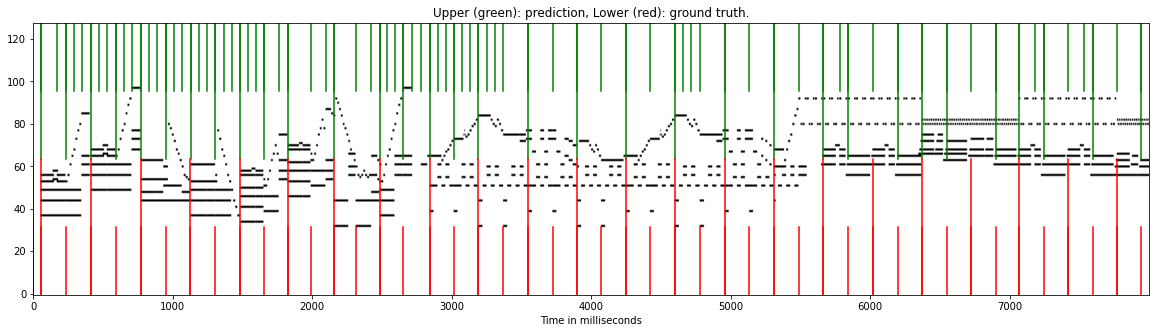

In [2]:
# Plot the beat prediction and pianoroll

import numpy as np
import pretty_midi as pm
import matplotlib.pyplot as plt

def get_piano_roll(midi_file, start_time, end_time):

    pr = np.zeros((128, int((end_time - start_time) * 100)))

    for instrument in pm.PrettyMIDI(midi_file).instruments:
        for note in instrument.notes:
            if note.start >= end_time or note.end <= start_time:
                continue
            start = int((note.start - start_time) * 100)
            end = int((note.end - start_time) * 100)

            pr[note.pitch, start:end] = 1
    
    return pr

start_time, end_time = 0, 80
beats_pred_seg = beats_pred[np.logical_and(beats_pred >= start_time, beats_pred <= end_time)]
beats_targ_seg = beats_targ[np.logical_and(beats_targ >= start_time, beats_targ <= end_time)]
downbeats_pred_seg = downbeats_pred[np.logical_and(downbeats_pred >= start_time, downbeats_pred <= end_time)]
downbeats_targ_seg = downbeats_targ[np.logical_and(downbeats_targ >= start_time, downbeats_targ <= end_time)]
pr_seg = get_piano_roll(midi_recording, start_time, end_time)

plt.figure(figsize=(20, 5))
plt.imshow(1-pr_seg, aspect='auto', origin='lower', cmap='gray')
for b in beats_pred_seg:
    plt.axvline(x=(b - start_time) * 100, ymin=0.75, ymax=1, color='green')
for b in beats_targ_seg:
    plt.axvline(x=(b - start_time) * 100, ymin=0, ymax=0.25, color='red')
for b in downbeats_pred_seg:
    plt.axvline(x=(b - start_time) * 100, ymin=0.5, ymax=1, color='green')
for b in downbeats_targ_seg:
    plt.axvline(x=(b - start_time) * 100, ymin=0, ymax=0.5, color='red')
plt.xlabel('Time in milliseconds')
plt.title('Upper (green): prediction, Lower (red): ground truth.')
plt.show()

## Quantisation from a MIDI performance

In [3]:
from pm2s.features.quantisation import RNNJointQuantisationProcessor

# Get one MIDI recording from the A_MAPS dataset
midi_recording = '/import/c4dm-05/ll307/datasets/A-MAPS_1.1/MAPS_MUS-bk_xmas1_ENSTDkCl.mid'

# Create a quantisation processor
processor = RNNJointQuantisationProcessor()

# Process the MIDI recording to the beat predictions
onset_positions, note_values = processor.process(midi_recording)
print('onset positions \t note values')
print('-' * 50)
for i in range(20):
    print('{:4f} \t\t {:.4f}'.format(onset_positions[i], note_values[i]))

onset positions 	 note values
--------------------------------------------------
0.000000 		 0.6667
0.000000 		 0.6667
1.000000 		 0.6667
1.000000 		 0.6667
1.000000 		 0.6667
1.500000 		 0.1667
1.500000 		 0.1667
1.666667 		 0.3333
1.666667 		 0.3333
1.666667 		 0.3333
1.666667 		 0.3333
2.666667 		 0.3333
2.000000 		 0.0833
2.000000 		 0.6667
2.000000 		 0.6667
3.000000 		 0.6667
3.083333 		 0.0833
3.166667 		 0.0833
3.250000 		 0.0833
4.333333 		 0.0833


## Hand part prediction

In [4]:
from pm2s.features.hand_part import RNNHandPartProcessor

# Get one MIDI recording from the A_MAPS dataset
midi_recording = '../../datasets/A-MAPS_1.1/MAPS_MUS-bk_xmas1_ENSTDkCl.mid'

# Create a hand part prediction processor
processor = RNNHandPartProcessor()

# Predict hand part for each note in the MIDI recording
hand_parts = processor.process(midi_recording)

print(hand_parts[:20])

[0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0]


## Time and key signature prediction

In [5]:
from pm2s.features.time_signature import CNNTimeSignatureProcessor
from pm2s.features.key_signature import RNNKeySignatureProcessor

# Get one MIDI recording from the A_MAPS dataset
midi_recording = '../../datasets/A-MAPS_1.1/MAPS_MUS-bk_xmas1_ENSTDkCl.mid'

# Create time and key processors
processor_time_sig = CNNTimeSignatureProcessor()
processor_key_sig = RNNKeySignatureProcessor()

# Prediction
time_signature = processor_time_sig.process(midi_recording)  # Single time signature prediction, assuming time signature does not change over the piece
key_signature_changes = processor_key_sig.process(midi_recording)

print("Time signature:")
print(time_signature)
print("\nKey signature changes:")
print(key_signature_changes)

Time signature:
3/4

Key signature changes:
[(0.5219849999999999, 'Db')]


## Performance MIDI to score conversion

In [6]:
from pm2s import crnn_joint_pm2s

performance_midi_file = '../../datasets/A-MAPS_1.1/MAPS_MUS-schuim-1_ENSTDkCl.mid'
score_midi_file = 'generated_score.mid'

# Convert and save the generated score midi
time2tick_dict = crnn_joint_pm2s(performance_midi_file, score_midi_file, start_time=0, end_time=300, include_time_signature=True, include_key_signature=True)